# Positional Encoding

It is a way to encode the position of the instance in the sequence. In transformer model, the absolute and relatvie position of the instance are lost since the model treat each instance independently (Time Distributed) and the model lost the sense of sequences when we dropped RNN layers.

Being that, we need somehow to encode the position of the instance and feed it to the network. Positional Encoding is a d-dimensional space that can be learned by the model, just like embeddings, however, the authors of transformer model preferred fixed positional encoding as both yields similar results and the model has less trainable parameters to learn.

The authors used vector of sines and consines to encode each position, where each sin-consine pair rotates at a different frequency. The idea is to make near by positions very similar (affinity).

The equation used to build the embeddings are:

$$
  \text{PE}_{(\text{pos}, 2i)} = \sin(\text{pos}/10000^{2i/d_{max}}) \\
  \text{PE}_{(\text{pos}, 2i+1)} = \cos(\text{pos}/10000^{2i/d_{max}})
$$

where $d_{max}$ should be an even number

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
max_seq_length = 50
max_depth = 512

assert max_depth % 2 == 0

i = np.arange(max_depth // 2)
positions = np.arange(max_seq_length)
print(positions.shape, i.shape)

(50,) (256,)


In [ ]:
pos, i = np.meshgrid(positions, i)
print(pos.shape, i.shape)

(256, 50) (256, 50)


In [ ]:
pos[1], i[1]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]))

In [ ]:
position_embed = np.empty((max_seq_length, max_depth))
# apply sin to even indices in the array
position_embed[:, 0::2] = np.sin(pos / 10000**(2 * i / max_depth)).T
# apply cos to odd indices in the array
position_embed[:, 1::2] = np.sin(pos / 10000**(2 * i / max_depth)).T

To identify that the closer positions have higher similarity than further positions:

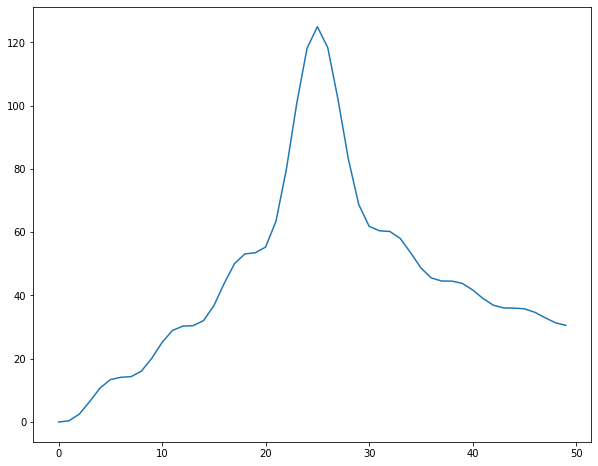

In [ ]:
# taking a position at the middle
a_pos = max_seq_length // 2
pos = position_embed[a_pos]
# we will check similarity by using the dot product
dots = np.dot(position_embed, pos)
# we plot the similarity now:
plt.figure(figsize=(10,8))
plt.plot(dots)
plt.show()

In [ ]:
import tensorflow as tf
from warnings import warn

class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self, max_length, max_depth, min_rate=1/10000, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        if max_depth % 2 != 0:
            warnings.warn("max_depth should be even, max_depth is incremented!")
            max_depth += 1

        pos = np.arange(max_length)
        i = np.arange(max_depth // 2)
        pos, i = np.meshgrid(pos, i)  # build the meshgrid of both pos and i
        embedding = np.empty((max_length, max_depth))
        embedding[:, ::2] = np.sin(pos * min_rate**(2 * i / max_depth)).T
        embedding[:, 1::2] = np.cos(pos * min_rate**(2 * i / max_depth)).T
        # new axis is added for batches dimension
        # as we would like to broadcast positional embedding for all instance in
        # the batch
        self.positional_embedding = tf.constant(embedding[np.newaxis, ...])
  
    def call(self, x):
        return x + self.positional_embedding

In [35]:
pos_encoder = PositionalEncoding(50, 512)
pos_encoder.positional_embedding.shape

TensorShape([1, 50, 512])

With that, The embedding layer will learn the relative position of the words (how the words are close in meaning) where as the positional layer will learn the absolute position of the word. Adding them together should shift the words and make it easier for the model to find similiarty and determine where to focus its attention while predicting the target.